In [4]:
%precision 4
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 100)
pd.set_option("precision", 4)

import datetime
import time

import matplotlib.pyplot as pyplot
%matplotlib inline

import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

import nltk
from nltk.stem.snowball import SnowballStemmer

import random
random.seed(42)
RANDOM_STATE = 42

import gc

import re
import distance
import json

### Загружаем и чистим данные

In [5]:
def merge_pairs_info(pairs, item_info):    
    merged_data = pairs
    
    for item_id in [1,2]:
        item_data = item_info[
            ['itemID',
             'categoryID',
             "title",
             "description",
             "images_array",
             "attrsJSON",
             'price',
             'locationID',
             'metroID',
             'lat',
             'lon', 
            ]
        ]

        item_data = pd.merge(item_data, category_info, how="left", on="categoryID", left_index=True)
        item_data = pd.merge(item_data, location_info, how="left", on="locationID", left_index=True)
        item_data = item_data.rename(
            columns={
                'itemID': 'itemID_'+str(item_id),
                'categoryID': 'categoryID_'+str(item_id),
                'parentCategoryID': 'parentCategoryID_'+str(item_id),
                "title": "title_"+str(item_id),
                "description": "description_"+str(item_id),
                "images_array": "images_array_"+str(item_id),
                "attrsJSON": "attrsJSON_"+str(item_id),
                'price': 'price_'+str(item_id),
                'locationID': 'locationID_'+str(item_id),
                'regionID': 'regionID_'+str(item_id),
                'metroID': 'metroID_'+str(item_id),
                'lat': 'lat_'+str(item_id),
                'lon': 'lon_'+str(item_id),
            }
        )

        merged_data = pd.merge(merged_data, item_data, how="left", on="itemID_"+str(item_id), left_index=True)

    del item_data
    gc.collect()
    
    return merged_data

In [6]:
TYPES_PAIRS_TRAIN = {
    'itemID_1': np.dtype(int),
    'itemID_2': np.dtype(int),
    'isDuplicate': np.dtype(int),
    'generationMethod': np.dtype(int),
}

TYPES_PAIRS_TEST = {
    'itemID_1': np.dtype(int),
    'itemID_2': np.dtype(int),
    'id': np.dtype(int)
}

TYPES_ITEM_INFO = {
    'itemID': np.dtype(int),
    'categoryID': np.dtype(int),
    'title': np.dtype(str),
    'description': np.dtype(str),
    'images_array': np.dtype(str),
    'attrsJSON': np.dtype(str),
    'price': np.dtype(float),
    'locationID': np.dtype(int),
    'metroID': np.dtype(float),
    'lat': np.dtype(float),
    'lon': np.dtype(float),
}

category_info = pd.read_csv("data\Category.csv")
location_info = pd.read_csv("data\Location.csv")

In [7]:
start_time = time.time()
print("Training: loading data...")
item_info_train = pd.read_csv("data\ItemInfo_train.csv", dtype=TYPES_ITEM_INFO)
item_info_train.fillna(value={
    'itemID': -1,
    'categoryID': -1,
    'title': "",
    'description': "",
    'images_array': "",
    'attrsJSON': "",
    'price': -1.0,
    'locationID': -1,
    'metroID': -1.0,
    'lat': -1.0,
    'lon': -1.0,
    }, inplace=True)
train_data = pd.read_csv("data\ItemPairs_train.csv", dtype=TYPES_PAIRS_TRAIN)
train_data = merge_pairs_info(pairs=train_data, item_info=item_info_train)
del item_info_train
gc.collect()
print("Training: loading completed in {} seconds".format(round(time.time() - start_time, 0)))

start_time = time.time()
print("Test: loading data...")
item_info_test = pd.read_csv("data\ItemInfo_test.csv", dtype=TYPES_ITEM_INFO)
item_info_test.fillna(value={
    'itemID': -1,
    'categoryID': -1,
    'title': "",
    'description': "",
    'images_array': "",
    'attrsJSON': "",
    'price': -1.0,
    'locationID': -1,
    'metroID': -1.0,
    'lat': -1.0,
    'lon': -1.0,
    }, inplace=True)
test_data = pd.read_csv("data\ItemPairs_test.csv", dtype=TYPES_PAIRS_TEST)
test_data = merge_pairs_info(pairs=test_data, item_info=item_info_test)
del item_info_test
gc.collect()
print("Test: loading completed in {} seconds".format(round(time.time() - start_time, 0)))

Training: loading data...
Training: loading completed in 75.0 seconds
Test: loading data...
Test: loading completed in 25.0 seconds


In [8]:
image_hashes = {}
start_time = time.time()
for part_id in range(0,11):
    print("Image hashes: loading part "+str(part_id))
    hashes_part = pd.read_csv("data\image_hashes_"+str(part_id)+".csv",
                            names=["index","images_id","image_hash"],
                            index_col=1,
                            skiprows=[0],
                            dtype={"index": np.dtype(int), "image_id": np.dtype(str), "image_hash": np.dtype(str)}
                           ).drop(["index"],axis=1)
    for image_id, image_hash in hashes_part.itertuples():
        image_hashes[image_id.rsplit('/', 1)[-1]] = image_hash
    del hashes_part
    gc.collect()

gc.collect()

print("Image hashes: loading completed in {} seconds".format(round(time.time() - start_time, 0)))

Image hashes: loading part 0
Image hashes: loading part 1
Image hashes: loading part 2
Image hashes: loading part 3
Image hashes: loading part 4
Image hashes: loading part 5
Image hashes: loading part 6
Image hashes: loading part 7
Image hashes: loading part 8
Image hashes: loading part 9
Image hashes: loading part 10
Image hashes: loading completed in 66.0 seconds


In [9]:
start_time = time.time()
import pickle
image_whashes = pickle.load(open("data\whash_haar.pkl","rb"))
print("Image whashes: loading completed in {} seconds".format(round(time.time() - start_time, 0)))

Image whashes: loading completed in 7.0 seconds


### Готовим признаки

#### Задаём вспомогательные функции

Общее

In [10]:
debug = False

In [11]:
def jaccard_index(set1, set2):
    if len(set1) == 0 and len(set2) == 0:
        return 0.0
    
    if debug: print(set1, set2)
    if debug: print(set1.intersection(set2), set1.union(set2))
    return len(set1.intersection(set2)) / float(len(set1.union(set2)))

Работа со строками

In [12]:
stemmer_russian = SnowballStemmer(language="russian", ignore_stopwords=True)
stemmer_english = SnowballStemmer(language="english", ignore_stopwords=True)

In [13]:
stopwords_russian = [word for word in nltk.corpus.stopwords.words("russian") if word!="не"]
stopwords_english = [word for word in nltk.corpus.stopwords.words("english")]
stopwords = stopwords_russian + stopwords_english

In [14]:
def jaccard_string(string1, string2):    
    list1 = re.findall("[\w']{2,}", string1.lower().replace("ё","е"))
    list2 = re.findall("[\w']{2,}", string2.lower().replace("ё","е"))
    
    if len(list1) == 0 and len(list2) == 0:
        return 0.0
    
    set1 = stem_strings(list1)
    set2 = stem_strings(list2)
    
    return jaccard_index(set1, set2)
jaccard_string_vectorized = np.vectorize(jaccard_string)

def stem_strings(word_list):
    word_set = set()
    for element in word_list:
        if element not in stopwords:
            if not re.search("[0-9a-z]", element):
                stemmed_element = stemmer_russian.stem(element) 
            else:
                stemmed_element = stemmer_english.stem(element) 
            word_set.add(stemmed_element)
    return word_set

Работа с JSON

In [15]:
def JSON_values_count(JSON_string):
    if len(JSON_string) == 0:
        return 0
    return len(json.loads(JSON_string).values())
JSON_values_count_vectorized = np.vectorize(JSON_values_count)

In [16]:
def jaccard_JSON(JSON_string1, JSON_string2):
    if len(JSON_string1) == 0 and len(JSON_string2) == 0:
        return 0.0
    
    if len(JSON_string1) != 0:
        JSON_set1 = set(json.loads(JSON_string1).items())
    else:
        JSON_set1 = set()
    
    if len(JSON_string2) != 0:
        JSON_set2 = set(json.loads(JSON_string2).items())
    else:
        JSON_set2 = set()
        
    return jaccard_index(JSON_set1, JSON_set2)
jaccard_JSON_vectorized = np.vectorize(jaccard_JSON)

Работа с хэшами изображений

In [17]:
def hDist(s1, s2):
    s1, s2 = str(s1), str(s2)
    return sum(bool(ord(ch1) - ord(ch2)) for ch1, ch2 in zip(s1, s2))

In [18]:
def whash_hdist(a1, a2):
    a1 = [int(x) for x in str(a1).split(',') if x.strip().isdigit()]
    a2 = [int(x) for x in str(a2).split(',') if x.strip().isdigit()]
    flowdist_ = 99
    if (len(a1) == 0) or (len(a2) == 0):
        if debug: print("В одном из объявлений нет фото\n")
        return flowdist_
    
    if debug: print(len(a1),a1)
    for ar1 in a1:
        if ar1 in image_whashes:
            for ar2 in a2:
                if ar2 in image_whashes:
                    z = hDist(image_whashes[ar1], image_whashes[ar2])
                    if z < flowdist_:
                        flowdist_ = int(z)
    return flowdist_
whash_hdist_vectorized = np.vectorize(whash_hdist)

In [19]:
def has_similar_images(images_array_1, images_array_2):
    if (images_array_1 == [""]) or (images_array_2 == [""]):
        if debug: print("В одном из объявлений нет фото\n")
        return False
    
    if debug: print(len(images_array_1), images_array_1)
    if debug: print(len(images_array_2), images_array_2)
    for image_1 in images_array_1:
        if debug: print("\nИмя 1: {}".format(image_1))
        matches_found = 0
        for image_2 in images_array_2:
            if debug: print("Имя 2: {}".format(image_2))
            if image_hashes[image_1] == image_hashes[image_2]:
                matches_found += 1
                if debug: print("Найдено совпадение хэшей")
                break
        if matches_found != 0:
            if debug: print("Хэши совпали\n")
            return True

    if debug: print("Хэши разные\n")
    return False

has_similar_images_vectorized = np.vectorize(has_similar_images)

In [20]:
def jaccard_hashes(images_array1, images_array2):
    if (images_array1 == [""]) or (images_array2 == [""]):
        return 0.0
    
    hashes_set1 = set([image_hashes[image_name] for image_name in images_array1])
    hashes_set2 = set([image_hashes[image_name] for image_name in images_array2])
    return jaccard_index(hashes_set1, hashes_set2)

jaccard_hashes_vectorized = np.vectorize(jaccard_hashes)

#### Генерируем признаки

In [21]:
start_time = time.time()
for data in (train_data, test_data):
#for data in [test_data]:
    print("Extracting simple features...")
    data['categoryID_same'] = np.equal(data['categoryID_1'], data['categoryID_2']).astype(np.int32)
    data['parentCategoryID_same'] = np.equal(data['parentCategoryID_1'], data['parentCategoryID_2']).astype(np.int32)
    data['title_same'] = np.equal(data['title_1'], data['title_2']).astype(np.int32)
    data['description_same'] = np.equal(data['description_1'], data['description_2']).astype(np.int32)
    data['images_array_same'] = np.equal(data['images_array_1'], data['images_array_2']).astype(np.int32)
    data['images_count_1'] = data["images_array_1"].str.split(", ").str.len().astype(np.int32)
    data['images_count_2'] = data["images_array_2"].str.split(", ").str.len().astype(np.int32)
    data['image_count_same'] = np.equal(data['images_count_1'], data['images_count_2']).astype(np.int32)
    data['attrsJSON_same'] = np.equal(data['attrsJSON_1'], data['attrsJSON_2']).astype(np.int32)
    data['locationID_same'] = np.equal(data['locationID_1'], data['locationID_2']).astype(np.int32)
    data['regionID_same'] = np.equal(data['regionID_1'], data['regionID_2']).astype(np.int32)
    
    print("Extracting complex features...")
    print("Finding presence of similar image hash...")
    data["has_similar_image_hashes"] = has_similar_images_vectorized(data["images_array_1"].str.split(", "),
                                                          data["images_array_2"].str.split(", ")).astype(np.int32)
    print("Calculating similarities for image hashes...")
    data["jaccard_index_hashes"] = jaccard_hashes_vectorized(data["images_array_1"].str.split(", "),
                                                          data["images_array_2"].str.split(", "))
    print("Calculating hDist based on whashes...")
    data["whashes_hdist"] = whash_hdist_vectorized(data["images_array_1"], data["images_array_2"])
    print("Calculating similarities for title...")
    data["jaccard_index_title"] = jaccard_string_vectorized(data['title_1'], data['title_2'])
    print("Calculating similarities for description...")
    data["jaccard_index_description"] = jaccard_string_vectorized(data['description_1'], data['description_2'])
    print("Calculating price relative difference...")
    data['price_relative_diff'] = np.divide(np.abs(data['price_1']-data['price_2']),
                                            np.abs(data['price_1']) + np.abs(data['price_2'])
                                           )
    print("Calculating location distance...")
    data['location_distance'] = np.power(np.power(data['lon_1']-data['lon_2'], 2) + \
                                         np.power(data['lat_1']-data['lat_2'], 2), \
                                         0.5)
    print("Calculating JSON values count for ID 1")
    data["JSON_values_count_1"] = JSON_values_count_vectorized(data["attrsJSON_1"])
    print("Calculating JSON values count for ID 2")
    data["JSON_values_count_2"] = JSON_values_count_vectorized(data["attrsJSON_2"])
    print("Calculating JSON values count equality")
    data["JSON_values_count_same"] = np.equal(data["JSON_values_count_1"], data["JSON_values_count_2"]).astype(np.int32)
    print("Calculating similarities for attrsJSON...")
    data["jaccard_index_attrsJSON"] = jaccard_JSON_vectorized(data["attrsJSON_1"], data["attrsJSON_2"])
    
    print("Deleting temporary data...")
    data.drop([
            'title_1',
            'title_2',
            'description_1',
            'description_2',
            'images_array_1',
            'images_array_2',
            'attrsJSON_1',
            'attrsJSON_2'],
              axis=1, inplace=True)
    data.fillna(-1, inplace=True)
    gc.collect()
    print("Done")

print("Feature extraction complete in {} seconds".format(round(time.time() - start_time, 2)))

Extracting simple features...
Extracting complex features...
Finding presence of similar image hash...
Calculating similarities for image hashes...
Calculating hDist based on whashes...
Calculating similarities for title...
Calculating similarities for description...
Calculating price relative difference...
Calculating location distance...
Calculating JSON values count for ID 1
Calculating JSON values count for ID 2
Calculating JSON values count equality
Calculating similarities for attrsJSON...
Deleting temporary data...
Done
Extracting simple features...
Extracting complex features...
Finding presence of similar image hash...
Calculating similarities for image hashes...
Calculating hDist based on whashes...
Calculating similarities for title...
Calculating similarities for description...
Calculating price relative difference...
Calculating location distance...
Calculating JSON values count for ID 1
Calculating JSON values count for ID 2
Calculating JSON values count equality
Calculat

In [222]:
need_replace = True
FEATURES_TO_DROP = []

In [223]:
start_time = time.time()
if need_replace:
    for data in (train_data, test_data):
        #data.drop(FEATURES_TO_DROP, axis=1, inplace=True)
        gc.collect()
        print("Calculating hDist based on whashes...")
        data["whashes_hdist"] = whash_hdist_vectorized(data["images_array_1"], data["images_array_2"])
        print("Done")
need_replace = False
print("Feature replacement complete in {} seconds".format(round(time.time() - start_time, 2)))

Calculating hDist based on whashes...
Done
Calculating hDist based on whashes...
Done
Feature replacement complete in 386.55 seconds


In [4]:
start_time = time.time()
train_data = pd.read_csv("features train 2016-07-11 07-17.csv.bz2", index_col=0)
test_data = pd.read_csv("features test 2016-07-11 07-22.csv.bz2", index_col=0)
print("Data loading complete in {} seconds".format(round(time.time() - start_time, 2)))

Data loading complete in 75.84 seconds


In [29]:
feature_names = list(
    set(list(train_data.columns.values))
  & set(list(test_data.columns.values))
)
feature_names.remove('itemID_1')
feature_names.remove('itemID_2')
#feature_names.remove('title_1')
#feature_names.remove('title_2')
#feature_names.remove('description_1')
#feature_names.remove('description_2')
#feature_names.remove('images_array_1')
#feature_names.remove('images_array_2')
#feature_names.remove('attrsJSON_1')
#feature_names.remove('attrsJSON_2')
print(feature_names)

['images_count_1', 'location_distance', 'lat_1', 'lon_1', 'lon_2', 'images_array_same', 'categoryID_2', 'lat_2', 'regionID_2', 'parentCategoryID_same', 'locationID_1', 'locationID_2', 'metroID_1', 'categoryID_same', 'JSON_values_count_1', 'jaccard_index_description', 'JSON_values_count_2', 'parentCategoryID_1', 'price_1', 'jaccard_index_hashes', 'whashes_hdist', 'image_count_same', 'images_count_2', 'description_same', 'regionID_same', 'locationID_same', 'JSON_values_count_same', 'price_relative_diff', 'attrsJSON_same', 'regionID_1', 'jaccard_index_title', 'categoryID_1', 'has_similar_image_hashes', 'price_2', 'metroID_2', 'jaccard_index_attrsJSON', 'parentCategoryID_2', 'title_same']


#### Выгружаем новые признаки в csv

In [49]:
start_time = time.time()
train_data.to_csv(
    "features train " + str(datetime.datetime.now().strftime("%Y-%m-%d %H-%M")) + ".csv.bz2",
    columns=feature_names + ["isDuplicate"],
    compression="bz2"
)
test_data.to_csv(
    "features test " + str(datetime.datetime.now().strftime("%Y-%m-%d %H-%M")) + ".csv.bz2",
    columns=feature_names,
    compression="bz2"
)
print("Feature saving complete in {} seconds".format(round(time.time() - start_time, 2)))

Feature saving complete in 387.66 seconds


### Обучаем модель

In [32]:
ETA = 0.1
MAX_DEPTH = 6
SUBSAMPLE = 0.8
COLSAMPLE_BYTREE = 0.8

TEST_SIZE = 0.1
NUM_BOOST_ROUND = 750
EARLY_STOPPING_ROUNDS = 10

In [33]:
start_time = time.time()

xgboost_params = {
    "objective": "binary:logistic",
    "booster" : "gbtree",
    "eval_metric": "auc",
    "eta": ETA,
    "max_depth": MAX_DEPTH,
    "subsample": SUBSAMPLE,
    "colsample_bytree": COLSAMPLE_BYTREE,
    "silent": 1,
    "seed": RANDOM_STATE
}

splitted_train, splitted_test = train_test_split(train_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

dtrain = xgb.DMatrix(splitted_train[feature_names], splitted_train["isDuplicate"])
dtest = xgb.DMatrix(splitted_test[feature_names], splitted_test["isDuplicate"])

watchlist = [(dtrain, 'train'),
             (dtest, 'eval')]

gbm = xgb.train(params=xgboost_params, \
             dtrain=dtrain, \
             num_boost_round=NUM_BOOST_ROUND, \
             evals=watchlist, \
             early_stopping_rounds=EARLY_STOPPING_ROUNDS, \
             verbose_eval=25)
print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))

Will train until eval error hasn't decreased in 10 rounds.
[0]	train-auc:0.869125	eval-auc:0.868752
[25]	train-auc:0.922889	eval-auc:0.922587
[50]	train-auc:0.930187	eval-auc:0.929851
[75]	train-auc:0.933741	eval-auc:0.933323
[100]	train-auc:0.936346	eval-auc:0.935894
[125]	train-auc:0.937779	eval-auc:0.937274
[150]	train-auc:0.939250	eval-auc:0.938642
[175]	train-auc:0.940529	eval-auc:0.939849
[200]	train-auc:0.941408	eval-auc:0.940645
[225]	train-auc:0.942317	eval-auc:0.941459
[250]	train-auc:0.943128	eval-auc:0.942174
[275]	train-auc:0.943795	eval-auc:0.942774
[300]	train-auc:0.944462	eval-auc:0.943363
[325]	train-auc:0.945056	eval-auc:0.943871
[350]	train-auc:0.945522	eval-auc:0.944262
[375]	train-auc:0.945997	eval-auc:0.944669
[400]	train-auc:0.946512	eval-auc:0.945102
[425]	train-auc:0.946882	eval-auc:0.945397
[450]	train-auc:0.947283	eval-auc:0.945733
[475]	train-auc:0.947663	eval-auc:0.946036
[500]	train-auc:0.948106	eval-auc:0.946388
[525]	train-auc:0.948457	eval-auc:0.946657


Training time: 83.98 minutes


[749]	train-auc:0.951125	eval-auc:0.948629


### Работа с полученной моделью

In [34]:
gbm.save_model("xgboost model " + str(datetime.datetime.now().strftime("%Y-%m-%d %H-%M")) + ".xgb")

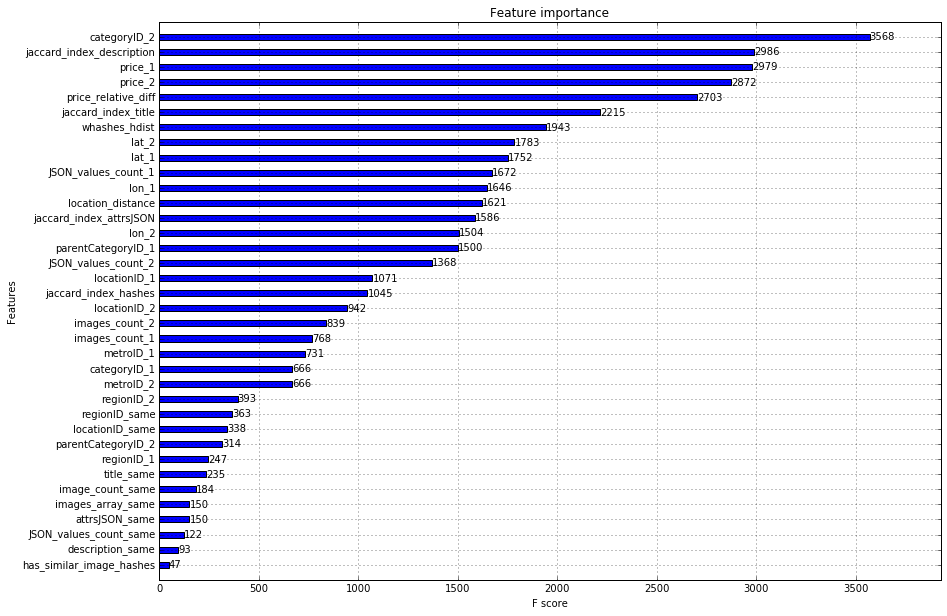

In [35]:
figure, axes = pyplot.subplots(figsize=(14,10))
xgb.plot_importance(gbm, ax=axes, height=0.4)

### Прогнозируем значения на тестовой выборке

In [36]:
test_predictions = gbm.predict(xgb.DMatrix(test_data[feature_names]), ntree_limit=gbm.best_ntree_limit).tolist()

### Строим ансамбль

In [38]:
from sklearn import ensemble
from sklearn.grid_search import GridSearchCV

train = train_data[feature_names]
test = test_data[feature_names]

N_ESTIMATORS=35
MAX_FEATURES=1.0
etc = ensemble.ExtraTreesClassifier(n_estimators=N_ESTIMATORS,
                                    max_depth=MAX_DEPTH,
                                    max_features=MAX_FEATURES,
                                    random_state=RANDOM_STATE,
                                    criterion='entropy',
                                    min_samples_split = 4, min_samples_leaf = 2, verbose = 0, n_jobs =-1)      
etr = ensemble.ExtraTreesRegressor(n_estimators=N_ESTIMATORS,
                                   max_depth=MAX_DEPTH,
                                   max_features=MAX_FEATURES,
                                   random_state=RANDOM_STATE,
                                   min_samples_split= 4, min_samples_leaf= 2, verbose = 0, n_jobs =-1)      
rfc = ensemble.RandomForestClassifier(n_estimators=N_ESTIMATORS,
                                      max_depth=MAX_DEPTH,
                                      max_features=MAX_FEATURES,
                                      random_state=RANDOM_STATE,
                                      criterion='entropy',
                                      min_samples_split= 4, min_samples_leaf= 2, verbose = 0, n_jobs =-1)
rfr = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                     max_depth=MAX_DEPTH,
                                     max_features=MAX_FEATURES,
                                     random_state=RANDOM_STATE,
                                     min_samples_split= 4, min_samples_leaf= 2, verbose = 0, n_jobs =-1)
xgr = xgb.XGBRegressor(n_estimators=N_ESTIMATORS,
                       max_depth=MAX_DEPTH,
                       seed=RANDOM_STATE,
                       missing=np.nan,
                       learning_rate=ETA,
                       subsample=SUBSAMPLE,
                       colsample_bytree=COLSAMPLE_BYTREE,
                       objective='reg:linear')
xgc = xgb.XGBClassifier(n_estimators=N_ESTIMATORS,
                        max_depth=MAX_DEPTH,
                        seed=RANDOM_STATE,
                        missing=np.nan,
                        learning_rate=ETA,
                        subsample=SUBSAMPLE,
                        colsample_bytree=COLSAMPLE_BYTREE,
                        objective='binary:logistic')
clf = {'xgr':xgr, 'xgc':xgc}

id_results = pd.DataFrame(test_data["id"].copy())

In [39]:
clf = {'xgr':xgr, 'xgc':xgc, 'etc':etc, 'etr':etr, 'rfc':rfc, 'rfr':rfr}

In [40]:
for c in clf:
    print("Started training model: ", c)
    y_pred=[]
    best_score = 0.0
    start_time = time.time()
    if c[:2] != "xg": #not xgb
        model = GridSearchCV(estimator=clf[c],
                             param_grid={},
                             n_jobs =-1,
                             cv=5,
                             verbose=0,
                             scoring="roc_auc")
        model.fit(train, train_data['isDuplicate'].values)
        if c[-1] != "c": #not classifier
            best_score = model.best_score_
            y_pred = model.predict(test)
        else: #classifier
            best_score = roc_auc_score(train_data['isDuplicate'].values, model.predict_proba(train)[:,1])
            y_pred = model.predict_proba(test)[:,1]
    else: #xgb
        X_fit, X_eval, y_fit, y_eval= train_test_split(train,
                                                       train_data['isDuplicate'],
                                                       test_size=TEST_SIZE,
                                                       random_state=RANDOM_STATE)
        model = clf[c]
        model.fit(X_fit,
                  y_fit.values,
                  early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                  eval_metric="auc",
                  eval_set=[(X_eval, y_eval)],
                  verbose=0)
        if c == "xgr": #xgb regressor
            best_score = roc_auc_score(train_data['isDuplicate'].values, model.predict(train))
            y_pred = model.predict(test)
        else: #xgb classifier
            best_score = roc_auc_score(train_data['isDuplicate'].values, model.predict_proba(train)[:,1])
            y_pred = model.predict_proba(test)[:,1]
    print("Ensemble Model: ", c,
          "Best score: ", best_score,
          "Minutes: ", round(((time.time() - start_time)/60),2))
    y_pred = np.clip(y_pred, 0.0, 1.0)
    id_results[c] = y_pred
    gc.collect()

Started training model:  rfr
Ensemble Model:  rfr Best score:  0.90216085853 Minutes:  29.49
Started training model:  etc
Ensemble Model:  etc Best score:  0.901009109578 Minutes:  21.19
Started training model:  etr
Ensemble Model:  etr Best score:  0.899695806111 Minutes:  18.0
Started training model:  rfc
Ensemble Model:  rfc Best score:  0.900746899948 Minutes:  49.58
Started training model:  xgr
Ensemble Model:  xgr Best score:  0.925189051115 Minutes:  3.61
Started training model:  xgc
Ensemble Model:  xgc Best score:  0.924399813481 Minutes:  3.69


In [41]:
id_results['avg'] = id_results.drop('id', axis=1).apply(np.average, axis=1)
ds = id_results[['id','avg']]
ds.columns = ['id','probability']
ds.to_csv("ensemble submission " + str(datetime.datetime.now().strftime("%Y-%m-%d %H-%M")) + ".csv", index=False)

### Выгружаем результаты

In [37]:
submission_csv_name = 'submission ' + str(datetime.datetime.now().strftime("%Y-%m-%d %H-%M")) + " scoring " + str(gbm.best_score) + '.csv'
print("Writing submission:", submission_csv_name)

with open(submission_csv_name, 'w') as file:
    file.write('id,probability\n')
    counter = 0
    for pair_id in test_data['id']:
        submission_item = str(pair_id) + "," + str(test_predictions[counter]) + "\n"
        counter += 1
        file.write(submission_item)

Writing submission: submission 2016-07-12 04-42 scoring 0.948629.csv


## Вспомогательные инструменты

### Смотрим ошибки классификации

In [67]:
prediction_data = train_data[["itemID_1", "itemID_2", "generationMethod","isDuplicate"]].copy()
prediction_data["prediction"] = gbm.predict(xgb.DMatrix(train_data[feature_names]), ntree_limit=gbm.best_ntree_limit)
prediction_data["error"] = np.abs(prediction_data["isDuplicate"] - prediction_data["prediction"])

In [79]:
prediction_data["generationMethod"].value_counts()

1    2041604
3     807878
2     141914
Name: generationMethod, dtype: int64

In [102]:
prediction_data.sort_values(by="error", ascending=False).iloc[:10,:]

,itemID_1,itemID_2,generationMethod,isDuplicate,prediction,error
403,72914,3039223,3,0,0.998818,0.998818
403,1303754,3039223,3,0,0.998653,0.998653
2536,5693996,6015459,3,1,0.001719,0.998281
1368,3381211,4626986,3,1,0.001756,0.998244
338,3219241,5648518,1,0,0.997751,0.997751
38,3952194,5244003,3,1,0.002458,0.997542
640,22346,2835102,1,0,0.997487,0.997487
1291,1121353,1133084,1,1,0.002619,0.997381
3318,1578169,5575967,1,0,0.997303,0.997303
3362,2813596,5707075,3,1,0.002758,0.997242


In [136]:
train_data.loc[(train_data["itemID_1"] == 2813596) & (train_data["itemID_2"] == 5707075),:].T

,3362
itemID_1,2813596
itemID_2,5707075
isDuplicate,1
generationMethod,3
categoryID_1,84
title_1,Samsynq 525
description_1,за все 1000 продам на запчасти или обмен на т...
images_array_1,"12689116, 14526615"
attrsJSON_1,"{""Вид телефона"":""iPhone""}"
price_1,1000


In [137]:
train_data.loc[(train_data["itemID_1"] == 2813596) & (train_data["itemID_2"] == 5707075),["description_1","description_2"]].values.tolist()

[['за все 1000 продам  на запчасти или обмен на телефон мтс (4623040)',
  'цена договорная !!! есть рабочие..писать тут  номер не доступен']]

### Обсчитываем хеши для изображений

In [2]:
#http://blog.iconfinder.com/detecting-duplicate-images-using-python/
import zipfile
import io
import datetime
from PIL import Image
from multiprocessing import Pool

In [76]:
def get_hashes_for_zip(zip_id):
    img_file = zipfile.ZipFile("data\Images_" + str(zip_id) + "".zip")
    print ("Processing Zip#" + str(zip_id))
    namelist = img_file.namelist()
    #namelist = img_file.namelist()[:15]
    
    img_id_hashes = []
    counter = 1
    for name in namelist:
        try:
            img_data = img_file.read(name)
            if len(img_data) > 0:
                img_id = name[:-4]
                img_hash = dhash(Image.open(io.BytesIO(img_data)))
                img_id_hashes.append([img_id, img_hash])
                counter += 1
            if (counter % 10000) == 0:
                print(datetime.date.strftime(datetime.datetime.now(),"%X"),"Zip#"+ str(zip_id) + ":", "{:.2f}".format(counter/len(namelist)*100.0)  + "% complete")
        except:
            print("Read error in Zip#" + str(zip_id), str(name))
    df = pd.DataFrame(img_id_hashes, columns=["image_id", "image_hash"])
    df.to_csv("data\image_hashes_" + str(zip_id) + ".csv")
    print("Zip#"+ str(zip_id) + "finished")

In [55]:
def dhash(image, hash_size = 32):
    image = image.convert('LA').resize((hash_size+1, hash_size), Image.ANTIALIAS)
    
    difference = []
    for row in range(hash_size):
        for col in range(hash_size):
            pixel_left = image.getpixel((col,row))
            pixel_right = image.getpixel((col+1,row))
            difference.append(pixel_left > pixel_right)
    
    decimal_value = 0
    
    hex_string = []
    for index, value in enumerate(difference):
        if value:
            decimal_value += 2**(index % 8)
        if (index % 8) == 7:
            hex_string.append(hex(decimal_value)[2:].rjust(2,'0'))
            decimal_value = 0
    
    return ''.join(hex_string)

In [ ]:
get_hashes_for_zip(5)
"""import os
import multiprocessing as mp
if __name__ == '__main__':
    pool = mp.Pool(processes=os.cpu_count()-1)
    pool.map(get_hashes_for_zip, [zip_id for zip_id in range(4,6)])
    pool.close()
    pool.join()"""